In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.FeatExtModels_NoKaiser import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Data

In [2]:
DATA = np.load('./Data/AsanTRSet.npy')

#### Env setting

In [3]:
save_path = './Results/'
if not os.path.exists(save_path):
    os.mkdir(save_path)
    
### Model checkpoint
ModelSaveSameName = save_path+'SigBandRepModel_ExtRec_check.hdf5'
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )

### Model Early stop
EarlyStop = EarlyStopping(monitor='val_loss', patience=500)

LatDim = 3
SigDim = DATA.shape[1]
MaskingRate = 0.02
NoiseStd = 0.002
MaskStd = 0.1
ReparaStd = 0.1

In [4]:
'''
class RelLossWeight(tf.keras.callbacks.Callback):
    def __init__(self, LossName1, LossName2, BetaName1, BetaName2, verbose=1):
                
        self.LossName1 = LossName1
        self.LossName2 = LossName2
        self.BetaName1 = BetaName1
        self.BetaName2 = BetaName2
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        
        Loss1 = logs[self.LossName1] 
        Loss2 = logs[self.LossName2] 
        
        Beta1_idx = [num for num, i in enumerate(self.model.variables) if self.BetaName1 in i.name][0]
        Beta2_idx = [num for num, i in enumerate(self.model.variables) if self.BetaName2 in i.name][0]
        
        self.model.variables[Beta1_idx].assign(Loss1/Loss2)
        self.model.variables[Beta2_idx].assign(Loss2/Loss1)   

        if self.verbose==1:
            print(self.BetaName1+' : ', self.model.variables[Beta1_idx])
            print(self.BetaName2+' : ', self.model.variables[Beta2_idx])        
 

# Define the KL annealing callback function
class KLCallback(tf.keras.callbacks.Callback):
    def __init__(self, TargetLossName, Threshold, MaxBeta, BetaName, AnnealEpoch=100):
        self.TargetLossName = TargetLossName
        self.Threshold = Threshold
        self.BetaName = BetaName
        self.MaxBeta = MaxBeta
        self.AnnealStart = 0
        self.AnnealEpoch = AnnealEpoch

    def on_epoch_end(self, epoch, logs={}):
        
        TargetLoss = logs['val_'+self.TargetLossName]
        
        if TargetLoss > self.Threshold:
            
            self.AnnealStart = 0
            K.set_value(self.model.get_layer(self.BetaName).variables[0], 0.)
        else: 
            self.AnnealStart += 1
            Beta = (self.AnnealStart) / self.AnnealEpoch * self.MaxBeta
            K.set_value(self.model.get_layer(self.BetaName).variables[0], Beta)
        
        print(self.model.get_layer(self.BetaName).variables[0])
'''

"\nclass RelLossWeight(tf.keras.callbacks.Callback):\n    def __init__(self, LossName1, LossName2, BetaName1, BetaName2, verbose=1):\n                \n        self.LossName1 = LossName1\n        self.LossName2 = LossName2\n        self.BetaName1 = BetaName1\n        self.BetaName2 = BetaName2\n        self.verbose = verbose\n\n    def on_epoch_end(self, epoch, logs={}):\n        \n        Loss1 = logs[self.LossName1] \n        Loss2 = logs[self.LossName2] \n        \n        Beta1_idx = [num for num, i in enumerate(self.model.variables) if self.BetaName1 in i.name][0]\n        Beta2_idx = [num for num, i in enumerate(self.model.variables) if self.BetaName2 in i.name][0]\n        \n        self.model.variables[Beta1_idx].assign(Loss1/Loss2)\n        self.model.variables[Beta2_idx].assign(Loss2/Loss1)   \n\n        if self.verbose==1:\n            print(self.BetaName1+' : ', self.model.variables[Beta1_idx])\n            print(self.BetaName2+' : ', self.model.variables[Beta2_idx])       

In [4]:
def ParaFilters (layer, name=''):
    Fc = Dense(1, activation='sigmoid')(layer)
    Fc = tf.clip_by_value(Fc, 1e-7, 1-1e-7)
    
    # Reparameterization Trick for sampling from Uniformly distribution; ϵ∼U(0,1) 
    Epsilon = tf.random.uniform(shape=(tf.shape(Fc)[0], Fc.shape[1]))
    Epsilon = tf.clip_by_value(Epsilon, 1e-7, 1-1e-7)

    LogEps = tf.math.log(Epsilon)
    LogNegEps = tf.math.log(1 - Epsilon)
    
    LogTheta = tf.math.log(Fc)
    LogNegTheta = tf.math.log(1-Fc)

    Fc = tf.math.sigmoid(LogEps - LogNegEps + LogTheta - LogNegTheta)
    Fc = tf.clip_by_value(Fc, 1e-7, 1-1e-7)
    Fc = ReName(Fc, name)
    
    return Fc 


class Lossweight(tf.keras.layers.Layer):
    
    def __init__(self, InitVal = 0., name='Lossweight'):
        super(Lossweight, self).__init__(name=name)
        self.InitVal = InitVal
    
    def build(self, input_shape):
        self.GenVec = tf.Variable(self.InitVal, trainable=False)
    
    def call(self, input):

        return self.GenVec
    
    def get_config(self):
        config = super(Lossweight, self).get_config()
        config.update({ 'InitVal': self.InitVal })
        return config
    

class RandFCs(tf.keras.layers.Layer):
    
    def __init__(self, ):
        super(RandFCs, self).__init__(name='FCs')
        pass
    
    def build(self, input_shape):
        self.GenVec = tf.Variable(tf.random.uniform(shape=(1,6)), trainable=False)
    
    def call(self, input):
        return tf.tile(self.GenVec , (tf.shape(input)[0],1))
    


class KLAnneal(tf.keras.callbacks.Callback):
    def __init__(self, TargetLossName, Threshold,  BetaName, MaxBeta=0.1, MinBeta=1e-5, AnnealEpoch=100, UnderLimit=0., verbose=1):
        
        if type(TargetLossName) != list:
            TargetLossName = [TargetLossName]
        
        self.TargetLossName = TargetLossName
        self.Threshold = Threshold
        self.BetaName = BetaName
        self.AnnealIdx = 0
        self.verbose = verbose 
        self.Beta =  np.concatenate([np.array([UnderLimit]), np.linspace(start=MinBeta, stop=MaxBeta, num=AnnealEpoch )])

    def on_epoch_end(self, epoch, logs={}):
        
        TargetLoss = max([logs[i] for i in self.TargetLossName]) 
        
        if TargetLoss > self.Threshold:
            
            self.AnnealIdx -= 1
            self.AnnealIdx = np.maximum(self.AnnealIdx, 0)
            K.set_value(self.model.get_layer(self.BetaName).variables[0], self.Beta[self.AnnealIdx])
        else: 
            self.AnnealIdx += 1
            self.AnnealIdx = np.minimum(self.AnnealIdx, len(self.Beta)-1)
            K.set_value(self.model.get_layer(self.BetaName).variables[0], self.Beta[self.AnnealIdx])
        
        if self.verbose==1:
            print(self.BetaName+' : ' ,self.model.get_layer(self.BetaName).variables[0].numpy())
        elif self.verbose==2:
            print('TargetLoss : ', TargetLoss)
            print(self.BetaName+' : ' ,self.model.get_layer(self.BetaName).variables[0].numpy())
            
            
       
class RelLossWeight(tf.keras.callbacks.Callback):
    def __init__(self, LossName1, LossName2, Beta1, Beta2, Weight =1., BetaName1 ='Beta1' , BetaName2 ='Beta2' , verbose=1):
                
        self.LossName1 = LossName1
        self.LossName2 = LossName2
        self.Beta1 = Beta1
        self.Beta2 = Beta2
        self.BetaName1 = BetaName1
        self.BetaName2 = BetaName2
        self.verbose = verbose
        self.Weight = Weight

    def on_epoch_end(self, epoch, logs={}):
        
        Loss1 = logs[self.LossName1] 
        Loss2 = logs[self.LossName2] 
        
        if Loss1>Loss2:
            Loss1 *= self.Weight
        elif Loss2>Loss1:
            Loss2 *= self.Weight
        
        self.Beta1.assign(Loss1/Loss2)
        self.Beta2.assign(Loss2/Loss1)   

        if self.verbose==1:
            print(self.BetaName1+' : ', self.Beta1.numpy())
            print(self.BetaName2+' : ', self.Beta2.numpy())   
            
        
def ReName (layer, name):
    return Lambda(lambda x: x, name=name)(layer)


In [5]:
def Encoder(SigDim, LatDim= 2, Type = '', MaskingRate = 0.025, NoiseStd = 0.002, MaskStd = 0.1, ReparaStd = 0.1 , Reparam = False):

    InpL = Input(shape=(SigDim,))
    InpFrame = tf.signal.frame(InpL, 100, 100)

    if Reparam:
        InpRegul = GaussianNoise(stddev=NoiseStd)(InpFrame, training=Reparam)
        MaskVec, NoisVec = MaskingGen(InpRegul, MaskingRate, MaskStd)
        EncInp = Masking(mask_value=0.)(InpRegul * MaskVec )
        EncOut = InpRegul + NoisVec
    else:
        EncInp, EncOut = InpFrame, InpFrame

    Encoder = Dense(50, activation='relu')(InpFrame)
    Encoder = Bidirectional(GRU(30, return_sequences=True))(Encoder)
    Encoder = Bidirectional(GRU(30, return_sequences=False))(Encoder)
    Encoder = Dense(50, activation='relu')(Encoder)
    Encoder = Dense(30, activation='relu')(Encoder)
    Encoder = Dense(15, activation='relu')(Encoder)

    Z_Mean = Dense(LatDim, activation='linear')(Encoder)
    Z_Log_Sigma = Dense(LatDim, activation='relu')(Encoder)
    Z_Log_Sigma = ReName(Z_Log_Sigma,'Z_Log_Sigma_'+Type)

    
    # Reparameterization Trick for sampling from Guassian distribution
    Epsilon = tf.random.normal(shape=(tf.shape(Z_Mean)[0], Z_Mean.shape[1]), mean=0., stddev=ReparaStd)

    if Reparam==False:
        Epsilon = Epsilon * 0

    Z_Mean = Z_Mean + tf.exp(0.5 * Z_Log_Sigma) * Epsilon
    Z_Mean = ReName(Z_Mean,'Z_Mean_'+Type)
    
    FCs =   Dense(6, activation='relu')(Z_Mean)
    FCs =   Dense(6, activation='sigmoid')(FCs)
    
    
    # Reparameterization Trick for sampling from Uniformly distribution; ϵ∼U(0,1) 
    FCs = tf.clip_by_value(FCs, 1e-7, 1-1e-7)
    Epsilon = tf.random.uniform(shape=(tf.shape(FCs)[0], FCs.shape[1]))
    Epsilon = tf.clip_by_value(Epsilon, 1e-7, 1-1e-7)
    
    LogEps = tf.math.log(Epsilon)
    LogNegEps = tf.math.log(1 - Epsilon)
    
    LogTheta = tf.math.log(FCs)
    LogNegTheta = tf.math.log(1-FCs)
    
    
    FCs = tf.math.sigmoid(LogEps - LogNegEps + LogTheta - LogNegTheta)
    FCs = tf.clip_by_value(FCs, 1e-7, 1-1e-7)
    FCs = ReName(FCs, 'FCs')
    
    return [InpL], [Flatten()(EncOut), Z_Mean, FCs]



def FeatExtractor(Inps, LatDim= 2, FiltLenList = [301, 301, 301, 301, 301, 301] ):
    
    EncReInp, InpZ, FCs = Inps
    
    H_F, L_F, HH_F, HL_F, LH_F, LL_F = tf.split(FCs, 6, axis=1)
    

    ### Filtering level 1 -------------------------------------------------------------------
    ## Filter generation
    To_H = GenHighFilter(H_F,  N=FiltLenList[0])
    To_L = GenLowFilter(L_F, N=FiltLenList[1])

    ## Perform signal filtering level 1
    InpFrame =  tf.signal.frame(EncReInp, To_H.shape[-1], 1)
    Sig_H = tf.reduce_sum(InpFrame*To_H[:,:,::-1], axis=-1, keepdims=True)
    Sig_H = ReName(Sig_H, 'Sig_H_Ext')

    InpFrame =  tf.signal.frame(EncReInp, To_L.shape[-1], 1)
    Sig_L = tf.reduce_sum(InpFrame*To_L[:,:,::-1], axis=-1, keepdims=True)
    Sig_L = ReName(Sig_L, 'Sig_L_Ext')



    ### Filtering level HH and HL (from Sig_H) -------------------------------------------------------------------
    ## Filter generation
    To_HH = GenHighFilter(HH_F, N=FiltLenList[2])
    To_HL = GenLowFilter(HL_F, N=FiltLenList[3])

    ## Perform signal filtering level 2
    Frame_H =  tf.signal.frame(Sig_H[:,:,0], To_HH.shape[-1], 1)
    Sig_HH = tf.reduce_sum(Frame_H*To_HH[:,:,::-1], axis=-1, keepdims=True)
    Sig_HH = ReName(Sig_HH, 'Sig_HH_Ext')

    Frame_H =  tf.signal.frame(Sig_H[:,:,0], To_HL.shape[-1], 1)
    Sig_HL = tf.reduce_sum(Frame_H*To_HL[:,:,::-1], axis=-1, keepdims=True)
    Sig_HL = ReName(Sig_HL, 'Sig_HL_Ext')


    ### Filtering level LH and LL (from Sig_L) -------------------------------------------------------------------
    ## Filter generation
    To_LH = GenHighFilter(LH_F,  N=FiltLenList[4])
    To_LL = GenLowFilter(LL_F,  N=FiltLenList[5])

    ## Perform signal filtering level 2
    Frame_L =  tf.signal.frame(Sig_L[:,:,0], To_LH.shape[-1], 1)
    Sig_LH = tf.reduce_sum(Frame_L*To_LH[:,:,::-1], axis=-1, keepdims=True)
    Sig_LH = ReName(Sig_LH, 'Sig_LH_Ext')

    Frame_L =  tf.signal.frame(Sig_L[:,:,0], To_LL.shape[-1], 1)
    Sig_LL = tf.reduce_sum(Frame_L*To_LL[:,:,::-1], axis=-1, keepdims=True)
    Sig_LL = ReName(Sig_LL, 'Sig_LL_Ext')

    
    return [Flatten()(Sig_HH), Flatten()(Sig_HL), Flatten()(Sig_LH), Flatten()(Sig_LL)]




def FeatGenerator (Inp_lat):
    
    Inp_lat = tf.concat(Inp_lat, axis=-1)
   
    Dec_Sig_HH = Dense(10, activation='relu')(Inp_lat)
    Dec_Sig_HH = Dense(20, activation='relu')(Dec_Sig_HH)
    Dec_Sig_HH = Dense(30, activation='relu')(Dec_Sig_HH)
    Dec_Sig_HH = Dense(50, activation='relu')(Dec_Sig_HH)

    Dec_Sig_HH = RepeatVector(10 )(Dec_Sig_HH)
    Dec_Sig_HH = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_HH)
    Dec_Sig_HH = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_HH)
    Dec_Sig_HH = Dense(40,'tanh')(Dec_Sig_HH)
    Sig_HH= Flatten(name='Sig_HH_Gen')(Dec_Sig_HH)
    
    # ---------------------------------------------------------------------- #
    
    Dec_Sig_HL = Dense(10, activation='relu')(Inp_lat)
    Dec_Sig_HL = Dense(20, activation='relu')(Dec_Sig_HL)
    Dec_Sig_HL = Dense(30, activation='relu')(Dec_Sig_HL)
    Dec_Sig_HL = Dense(50, activation='relu')(Dec_Sig_HL)

    Dec_Sig_HL = RepeatVector(10 )(Dec_Sig_HL)
    Dec_Sig_HL = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_HL)
    Dec_Sig_HL = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_HL)
    Dec_Sig_HL = Dense(40,'tanh')(Dec_Sig_HL)
    Sig_HL= Flatten(name='Sig_HL_Gen')(Dec_Sig_HL)
    
    # ---------------------------------------------------------------------- #
    
    Dec_Sig_LH = Dense(10, activation='relu')(Inp_lat)
    Dec_Sig_LH = Dense(20, activation='relu')(Dec_Sig_LH)
    Dec_Sig_LH = Dense(30, activation='relu')(Dec_Sig_LH)
    Dec_Sig_LH = Dense(50, activation='relu')(Dec_Sig_LH)

    Dec_Sig_LH = RepeatVector(10 )(Dec_Sig_LH)
    Dec_Sig_LH = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_LH)
    Dec_Sig_LH = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_LH)
    Dec_Sig_LH = Dense(40,'tanh')(Dec_Sig_LH)
    Sig_LH= Flatten(name='Sig_LH_Gen')(Dec_Sig_LH)
    
    # ---------------------------------------------------------------------- #
    
    Dec_Sig_LL = Dense(10, activation='relu')(Inp_lat)
    Dec_Sig_LL = Dense(20, activation='relu')(Dec_Sig_LL)
    Dec_Sig_LL = Dense(30, activation='relu')(Dec_Sig_LL)
    Dec_Sig_LL = Dense(50, activation='relu')(Dec_Sig_LL)

    Dec_Sig_LL = RepeatVector(10 )(Dec_Sig_LL)
    Dec_Sig_LL = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_LL)
    Dec_Sig_LL = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_LL)
    Dec_Sig_LL = Dense(40,'tanh')(Dec_Sig_LL)
    Sig_LL= Flatten(name='Sig_LL_Gen')(Dec_Sig_LL)
    
    return  Sig_HH, Sig_HL, Sig_LH, Sig_LL




def Reconstructor(Inps ):
    Sig_HH, Sig_HL, Sig_LH, Sig_LL = Inps

    ## GRU NET -------------------------------------------------------------------
    Dec_Sig_HH = Reshape((-1, 100))(Sig_HH)
    Dec_Sig_HL = Reshape((-1, 100))(Sig_HL)
    Dec_Sig_LH = Reshape((-1, 100))(Sig_LH)
    Dec_Sig_LL = Reshape((-1, 100))(Sig_LL)

    Dec_Sig_HH = Bidirectional(GRU(5), name='Dec_Sig_HH')(Dec_Sig_HH)
    Dec_Sig_HL = Bidirectional(GRU(5), name='Dec_Sig_HL')(Dec_Sig_HL)
    Dec_Sig_LH = Bidirectional(GRU(5), name='Dec_Sig_LH')(Dec_Sig_LH)
    Dec_Sig_LL = Bidirectional(GRU(5), name='Dec_Sig_LL')(Dec_Sig_LL)

    Decoder = tf.concat([ Dec_Sig_HH, Dec_Sig_HL, Dec_Sig_LH, Dec_Sig_LL], axis=1)
    Decoder = RepeatVector((SigDim//100) )(Decoder)
    Decoder = Bidirectional(GRU(50, return_sequences=True))(Decoder)
    Decoder = Dense(100, activation='relu')(Decoder)
    DecOut = Dense(100, activation='sigmoid')(Decoder)
    DecOut = Reshape((SigDim,),name='Out')(DecOut)

    
    return DecOut

In [6]:
### Encoder - FeatExtractor
EncInp, EncOut = Encoder(SigDim=SigDim, LatDim= LatDim, Type = 'Tr', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, Reparam=True)
FeatExtOut = FeatExtractor(EncOut)

### Encoder - FeatGenerator - Reconstruction
FeatGenOut = FeatGenerator(EncOut[1:])
FeatGenOut = ReName(FeatGenOut, 'FeatGenOut')

ReconOut = Reconstructor(FeatExtOut)
ReconOut = ReName(ReconOut, 'ReconOut')

### Define the total model
SigBandRepModel = Model(EncInp, ReconOut)

SigBandRepModel.add_weight(initializer=tf.constant_initializer(value=1.0), name='Beta_Rec', trainable=False)
SigBandRepModel.add_weight(initializer=tf.constant_initializer(value=1.0), name='Beta_Feat', trainable=False)
Beta_Rec = [i for i in SigBandRepModel.variables if 'Beta_Rec' in i.name][0]
Beta_Feat = [i for i in SigBandRepModel.variables if 'Beta_Feat' in i.name][0]


### Weight controller; Apply beta and capacity 
Capacity = 0.1 # 0.1 0.05
Beta_Z = Lossweight(name='Beta_Z')(FeatGenOut)
Beta_Fc = Lossweight(name='Beta_Fc')(FeatGenOut)


### Custom loss for Reconstruction
def RECMSE (y_true, y_pred):
    
    RecMSE = tf.losses.mse(y_true, y_pred)
    RecMSE *= Beta_Rec
    
    return RecMSE


### Adding the FeatRecLoss; It allows connection between the extractor and generator
MSE = tf.keras.losses.MeanSquaredError()
FeatRecLoss= MSE(tf.concat(FeatGenOut, axis=-1), tf.concat(FeatExtOut, axis=-1))

SigBandRepModel.add_loss(FeatRecLoss * Beta_Feat.numpy() )
SigBandRepModel.add_metric(FeatRecLoss, 'FeatRecLoss')

### KL Divergence for p(Z) vs q(Z)
Z_Sampled, Z_Log_Sigma = SigBandRepModel.get_layer('Z_Mean_Tr').output, SigBandRepModel.get_layer('Z_Log_Sigma_Tr').output
kl_Loss_Z = 0.5 * tf.reduce_sum( Z_Sampled**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss_Z = tf.reduce_mean(kl_Loss_Z )
kl_Loss_Z = Beta_Z * tf.abs(kl_Loss_Z - Capacity)

### KL Divergence for p(FCs) vs q(FCs)
BernP = 0.5 # hyperparameter
FCs = SigBandRepModel.get_layer('FCs').output
kl_Loss_FC = tf.math.log(FCs) - tf.math.log(BernP) + tf.math.log(1-FCs) - tf.math.log(1-BernP) 
kl_Loss_FC = tf.reduce_mean(-kl_Loss_FC )
kl_Loss_FC = Beta_Fc * tf.abs(kl_Loss_FC - 0.6)

SigBandRepModel.add_loss(kl_Loss_Z )
SigBandRepModel.add_metric(kl_Loss_Z, 'kl_Loss_Z')

SigBandRepModel.add_loss(kl_Loss_FC )
SigBandRepModel.add_metric(kl_Loss_FC, 'kl_Loss_FC')


## Model Compile
SigBandRepModel.compile(loss=RECMSE, optimizer='adam', metrics={"ReconOut":'mse'}) 

### Loss and KLD_Beta controller
KLD_Beta_Z = KLAnneal(TargetLossName=['val_FeatRecLoss', 'val_mse'], Threshold=0.001, BetaName='Beta_Z',  MaxBeta=0.01 , MinBeta=0.01, AnnealEpoch=1, UnderLimit=1e-7, verbose=2)
KLD_Beta_Fc = KLAnneal(TargetLossName=['val_FeatRecLoss', 'val_mse'], Threshold=0.001, BetaName='Beta_Fc',  MaxBeta=0.01 , MinBeta=0.01, AnnealEpoch=1, UnderLimit=1e-7, verbose=1)
RelLoss = RelLossWeight('val_mse', 'val_FeatRecLoss', Beta_Rec, Beta_Feat, verbose=1,Weight=10.)

In [76]:
#SigBandRepModel.load_weights(ModelSaveSameName)
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )

SigBandRepModel.fit(DATA[:], DATA[:], batch_size=3500, epochs=700, shuffle=True, validation_split=0.2, callbacks=[EarlyStop, ModelSave, KLD_Beta_Z, KLD_Beta_Fc, RelLoss])

Epoch 1/700
92/92 [==============================] - 71s 551ms/step - loss: 0.0418 - mse: 0.0264 - FeatRecLoss: 0.0080 - kl_Loss_Z: 0.0000e+00 - kl_Loss_FC: 0.0000e+00 - val_loss: 0.0118 - val_mse: 0.0091 - val_FeatRecLoss: 0.0027 - val_kl_Loss_Z: 0.0000e+00 - val_kl_Loss_FC: 0.0000e+00

Epoch 00001: val_mse improved from inf to 0.00906, saving model to ./Results\SigBandRepModel_ExtRec_check.hdf5
TargetLoss :  0.009058106690645218
Beta_Z :  1e-07
Beta_Fc :  1e-07
Beta1 :  33.051273
Beta2 :  0.03025602
Epoch 2/700
92/92 [==============================] - 47s 514ms/step - loss: 0.2862 - mse: 0.0086 - FeatRecLoss: 0.0025 - kl_Loss_Z: 5.6949e-07 - kl_Loss_FC: 2.5183e-08 - val_loss: 0.2660 - val_mse: 0.0080 - val_FeatRecLoss: 0.0025 - val_kl_Loss_Z: 5.3756e-07 - val_kl_Loss_FC: 2.0559e-08

Epoch 00002: val_mse improved from 0.00906 to 0.00797, saving model to ./Results\SigBandRepModel_ExtRec_check.hdf5
TargetLoss :  0.00797323975712061
Beta_Z :  1e-07
Beta_Fc :  1e-07
Beta1 :  32.377388
Bet

KeyboardInterrupt: 

In [ ]:
SigBandRepModel.load_weights(ModelSaveSameName)

(array([  58.,   57.,  101.,  127.,  141.,  219.,  328.,  496.,  928.,
        2545.]),
 array([0.00382998, 0.10344684, 0.2030637 , 0.30268055, 0.4022974 ,
        0.50191426, 0.60153115, 0.701148  , 0.80076486, 0.9003817 ,
        0.99999857], dtype=float32),
 <BarContainer object of 10 artists>)

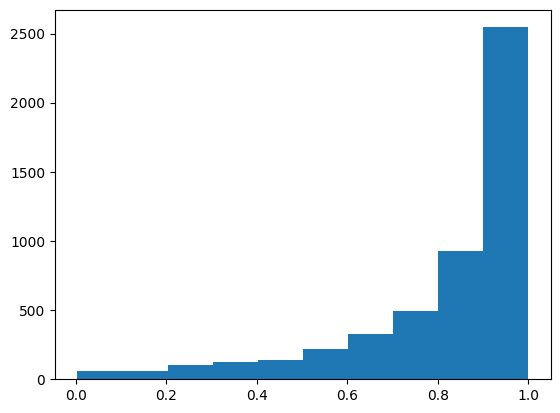

In [73]:
res = []
for i in range (5000):

    FCs = 0.9
    FCs = tf.clip_by_value(FCs, 1e-7, 1-1e-7)
    Epsilon = tf.random.uniform(shape=(1, 1))
    Epsilon = tf.clip_by_value(Epsilon, 1e-7, 1-1e-7)

    LogEps = tf.math.log(Epsilon)
    LogNegEps = tf.math.log(1 - Epsilon)

    LogTheta = tf.math.log(FCs)
    LogNegTheta = tf.math.log(1-FCs)


    res.append(tf.math.sigmoid(LogEps - LogNegEps + LogTheta - LogNegTheta).numpy())
    
plt.hist(np.concatenate(res))